In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision.utils import save_image, make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import yaml
import os
import argparse
import numpy as np
from tqdm.autonotebook import tqdm
from PIL import Image
from model.CDIFFUSE.cdiffusenet import CDiffuseNet
from runners.utils import mkdir

In [2]:
def show_images(imgs, num_rows, num_cols, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    return axes

In [3]:
mkdir('./jupyter samples/CDIFFUSE samples')

def save_sample_img(all_samples, subpath, grid_size=4):
    imgs = []
    sample_path = './jupyter samples/CDIFFUSE samples'
    sample_path = os.path.join(sample_path, subpath)
    mkdir(sample_path)
    
    for i, sample in enumerate(tqdm(all_samples, total=len(all_samples), desc='saving images')):
        sample = sample.view(grid_size ** 2, config.data.channels, config.data.image_size,
                                config.data.image_size)

        image_grid = make_grid(sample, nrow=grid_size)
        if i % 10 == 0:
            im = Image.fromarray(
                image_grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
            imgs.append(im)

        if i % 50 == 0:
            save_image(image_grid, os.path.join(sample_path, 'image_{}.png'.format(i)))
    
    image_grid = make_grid(all_samples[-1], nrow=grid_size)
    im = Image.fromarray(
                image_grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
    imgs.append(im)
    save_image(image_grid, os.path.join(sample_path, 'image_{}.png'.format(len(all_samples))))
    imgs[0].save(os.path.join(sample_path, "movie.gif"), save_all=True, append_images=imgs[1:],
                duration=1, loop=0)

In [4]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

config = None
with open('./configs/CDIFFUSE.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2namespace(config)
config.device = torch.device('cuda:0')
batch_size = config.training.batch_size

## 加载数据集

In [5]:
trans = transforms.Compose([
        transforms.Resize(config.data.image_size),
        transforms.ToTensor()
    ])
fashion_mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=trans, download=True)

## 加载模型

In [7]:
cdiffusenet = CDiffuseNet(config).to(config.device)
states = torch.load('./output/CDIFFUSE/CDIFFUSE/model/checkpoint.pth')
cdiffusenet.load_state_dict(states[0])
cond_transform = torchvision.transforms.RandomHorizontalFlip(p=1.0) 

# 1. CDIFFUSE前向过程

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

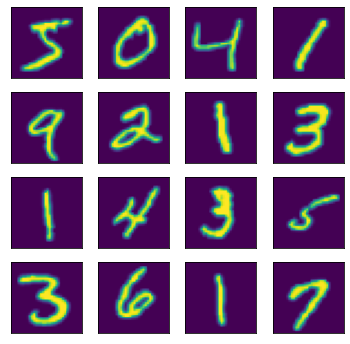

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size)))
X = X.to(config.device)
X_cond = cond_transform(X)
show_images(X.to('cpu').reshape(batch_size, 32, 32), 4, batch_size // 4)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

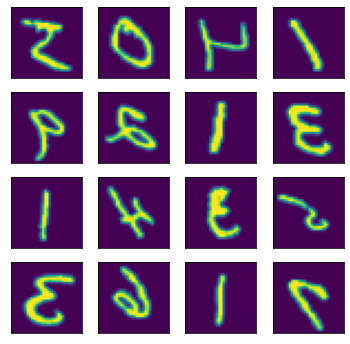

In [9]:
show_images(X_cond.to('cpu').reshape(batch_size, 32, 32), 4, batch_size // 4)

In [11]:
imgs = [X]
for i in tqdm(range(config.model.n_steps), desc='q_sample', total=config.model.n_steps):
    t = torch.full((batch_size,), i).to(config.device)
    img = cdiffusenet.q_sample(X, X_cond, t)
    imgs.append(img[0])

save_sample_img(imgs, 'forward_process')

q_sample:   0%|          | 0/200 [00:00<?, ?it/s]

saving images:   0%|          | 0/201 [00:00<?, ?it/s]

<img src="./jupyter samples/CDIFFUSE samples/forward_process/movie.gif" width=250 align="left">

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

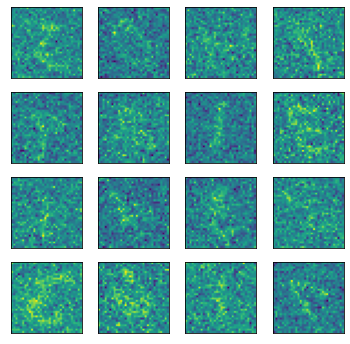

In [12]:
show_images(imgs[-1].to('cpu').reshape(batch_size, 32, 32), 4, batch_size // 4)

# 2. CDIFFUSE采样训练数据集

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

saving images:   0%|          | 0/200 [00:00<?, ?it/s]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

/home/x/.conda/envs/ML/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/x/.conda/envs/ML/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


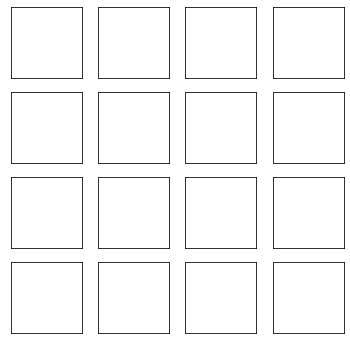

In [13]:
all_samples = cdiffusenet.p_sample_loop(X_cond)
save_sample_img(all_samples, 'train_sample')
show_images(all_samples[-1].to('cpu').reshape(batch_size, 32, 32), 4, batch_size // 4)

<img src="./jupyter samples/CDIFFUSE samples/train_sample/movie.gif" width=250 align="left">

# 3. CDIFFUSE采样测试数据集

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

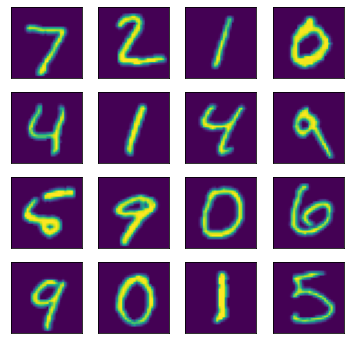

In [14]:
test_X, test_y = next(iter(data.DataLoader(mnist_test, batch_size=16)))
show_images(test_X.reshape(16, 32, 32), 4, 4)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

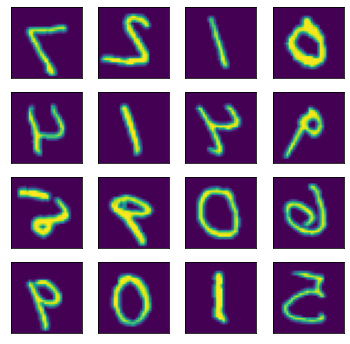

In [19]:
test_X = test_X.to(config.device)
test_X_cond = X_cond = cond_transform(test_X)
show_images(test_X_cond.to('cpu').reshape(batch_size, 32, 32), 4, batch_size // 4)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

saving images:   0%|          | 0/200 [00:00<?, ?it/s]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

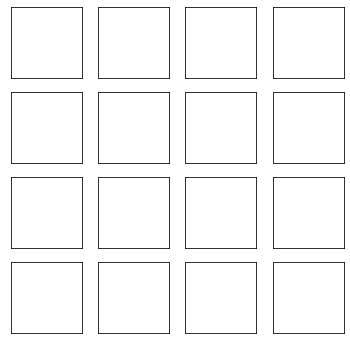

In [16]:
all_samples = cdiffusenet.p_sample_loop(test_X_cond)
save_sample_img(all_samples, 'test_sample')

<img src="./jupyter samples/CDIFFUSE samples/test_sample/movie.gif" width=250 align="left">